In [5]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table
from sklearn.model_selection import train_test_split


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [6]:
df_raw = load_fraud_data()
df_feats = build_fraud_feature_table(df_raw, 'Time', 'Amount', 'Class')

target_col = 'Class'
X = df_feats.drop(columns=[target_col])
y = df_feats[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (227845, 34) Test: (56962, 34)


In [7]:
drift_results = []

for col in X_train.columns:
    train_vals = X_train[col].values
    test_vals = X_test[col].values

    if np.issubdtype(train_vals.dtype, np.number):
        stat, pval = ks_2samp(train_vals, test_vals)
        drift_results.append((col, stat, pval))

drift_df = pd.DataFrame(drift_results, columns=['feature', 'ks_stat', 'p_value'])
drift_df.sort_values('p_value', inplace=True)

drift_df.head(20)


,feature,ks_stat,p_value
12,V12,0.007352,0.014438
16,V16,0.006687,0.033816
19,V19,0.005707,0.102354
8,V8,0.005476,0.129562
31,time_hours,0.005382,0.142153
0,Time,0.005382,0.142153
9,V9,0.005193,0.170509
25,V25,0.004705,0.264440
11,V11,0.004513,0.310381
32,time_seconds_mod_day,0.004475,0.320129


Top drifting features: ['V12', 'V16', 'V19', 'V8', 'time_hours']


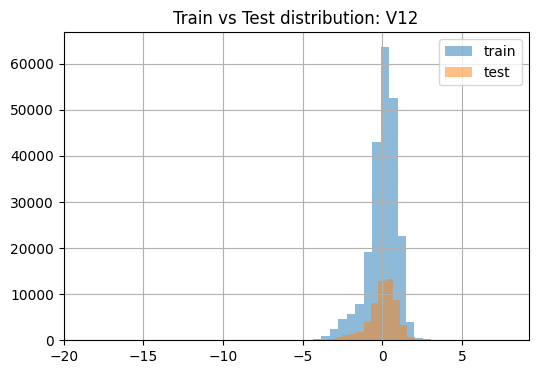

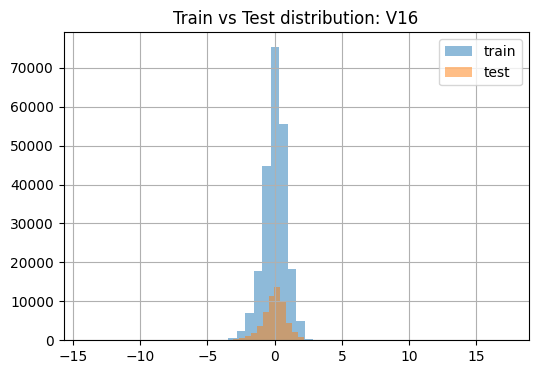

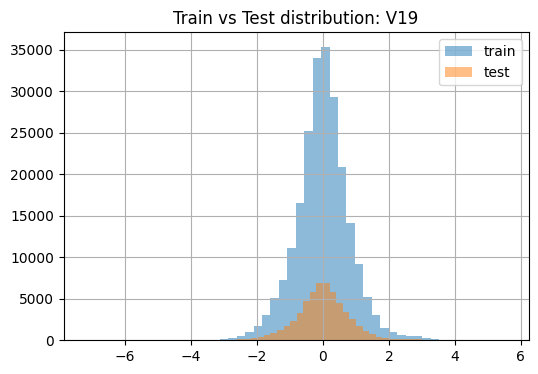

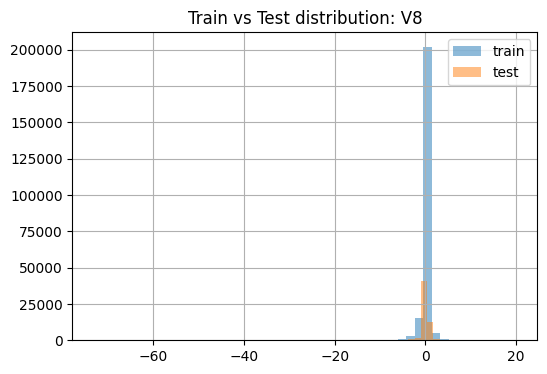

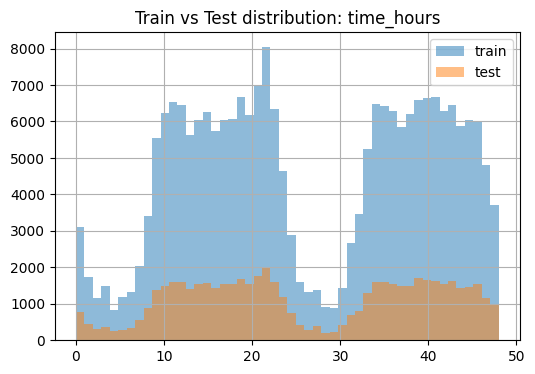

In [8]:
top_drifting = drift_df.head(5)['feature'].tolist()
print('Top drifting features:', top_drifting)

for col in top_drifting:
    plt.figure(figsize=(6, 4))
    X_train[col].hist(alpha=0.5, label='train', bins=50)
    X_test[col].hist(alpha=0.5, label='test', bins=50)
    plt.title(f'Train vs Test distribution: {col}')
    plt.legend()
    plt.show()
